In [1]:
import numpy as np
from scipy import sparse
import scanpy as sc
import pandas as pd
import scgen
from matplotlib import pyplot as plt
import os
import tensorflow as tf

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [6]:
SCATAC_DIR = '../data/scATAC/peaks/'

In [7]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')
scatac

CPU times: user 1.42 s, sys: 3min 55s, total: 3min 56s
Wall time: 3min 55s


AnnData object with n_obs × n_vars = 70461 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    obsm: 'X_umap'

In [8]:
network = scgen.VAEArithKeras(scatac.shape[1], z_dimension=10, learning_rate=0.0001,
                              loss_fn='binary_crossentropy', alpha=0.01, model_path='./models/scatac')

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20002)             0         
_________________________________________________________________
encoder (Model)              (None, 10)                16664020  
_________________________________________________________________
decoder (Model)              (None, 20002)             16676002  
Total params: 33,340,022
Trainable params: 33,333,622
Non-trainable params: 6,400
_________________________________________________________________


In [9]:
history = network.train(scatac, n_epochs=30, batch_size=64, verbose=1)


Epoch 1/30
70461/70461 [==============================] - 40s 563us/step - loss: 8604.4843 - kl_loss: 135.2947 - _loss: 8603.1328
Epoch 2/30
70461/70461 [==============================] - 40s 574us/step - loss: 8340.0940 - kl_loss: 175.6498 - _loss: 8338.3320
Epoch 3/30
70461/70461 [==============================] - 40s 575us/step - loss: 8307.4804 - kl_loss: 181.0694 - _loss: 8305.6699
Epoch 4/30
70461/70461 [==============================] - 40s 573us/step - loss: 8293.2402 - kl_loss: 188.1639 - _loss: 8291.3623
Epoch 5/30
70461/70461 [==============================] - 40s 572us/step - loss: 8284.0501 - kl_loss: 187.5191 - _loss: 8282.1748
Epoch 6/30
70461/70461 [==============================] - 41s 576us/step - loss: 8276.8225 - kl_loss: 183.0333 - _loss: 8274.9922
Epoch 7/30
70461/70461 [==============================] - 40s 574us/step - loss: 8272.7207 - kl_loss: 177.2898 - _loss: 8270.9453
Epoch 8/30
70461/70461 [==============================] - 41s 575us/step - loss: 8269.514

# Analysis

In [10]:
adata = scatac

### UMAP of the latent space

In [11]:
adata_latent = network.to_latent(adata.X)
adata_latent = sc.AnnData(adata_latent)
adata_latent.obs = adata.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

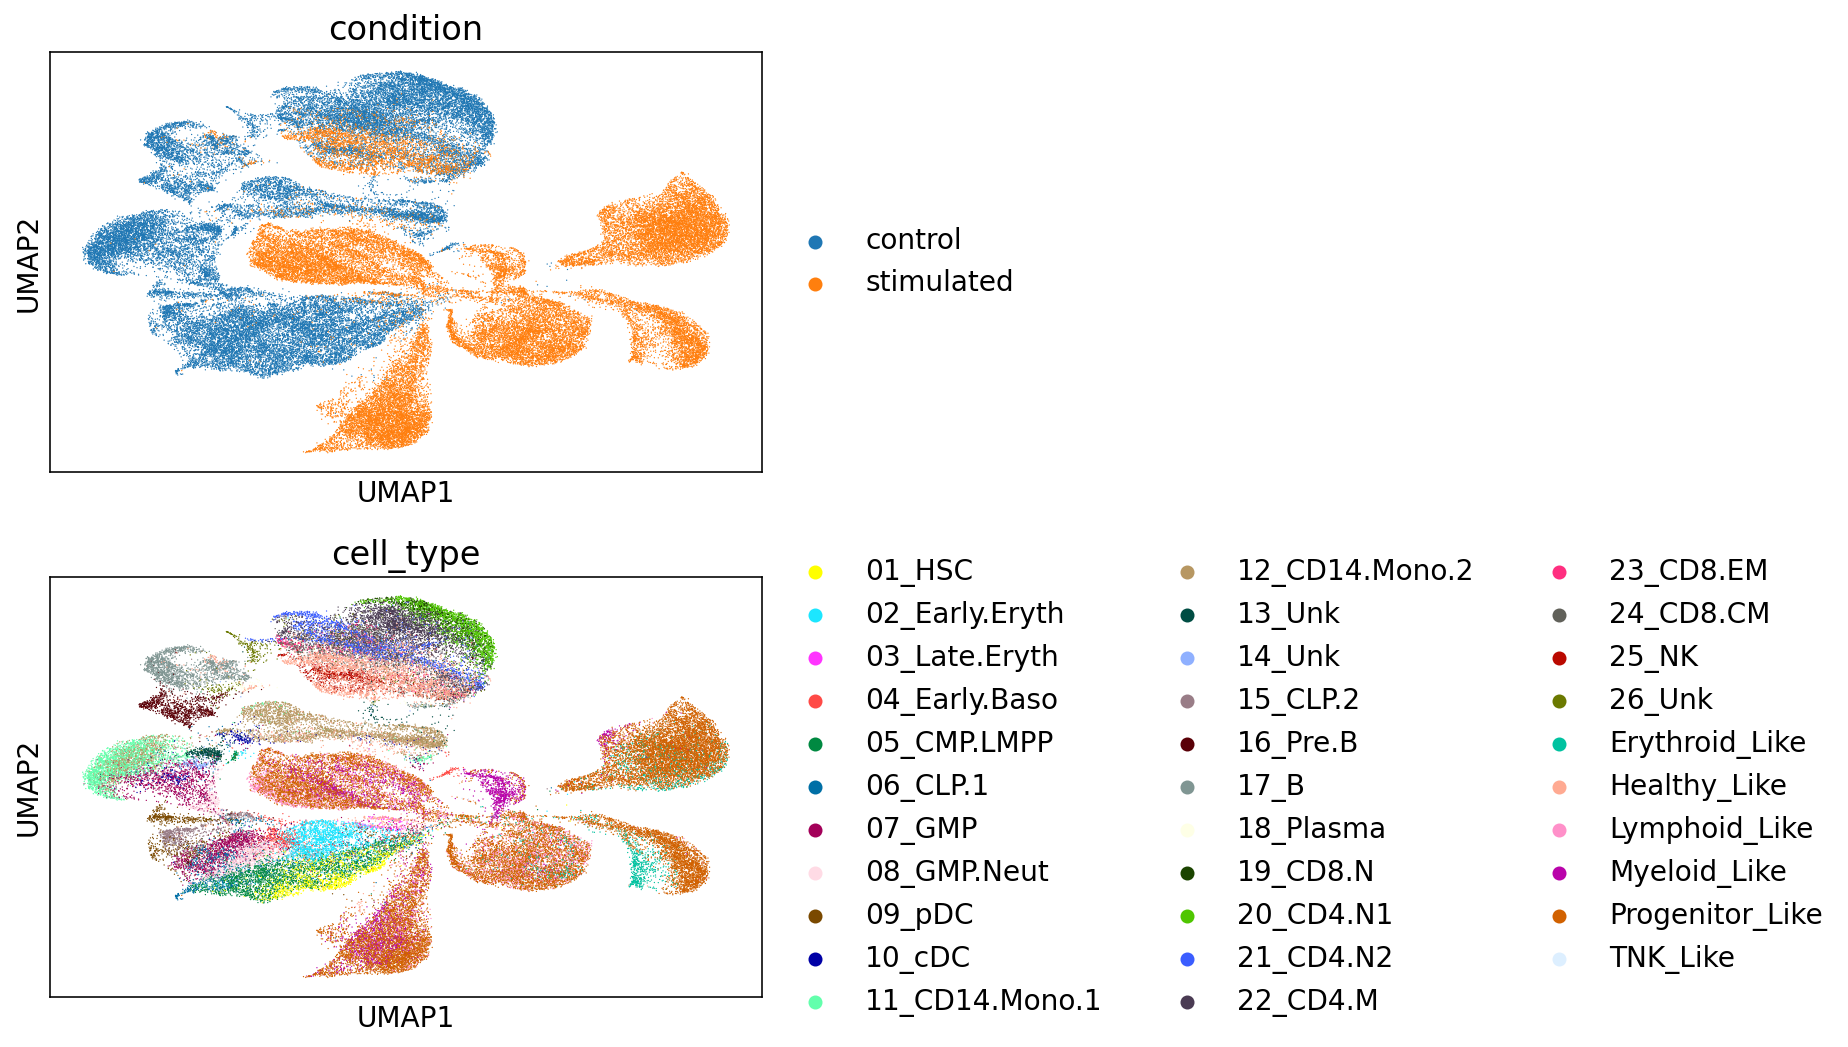

In [12]:
sc.pp.neighbors(adata_latent, random_state=42)
sc.tl.umap(adata_latent, random_state=42)
sc.pl.umap(adata_latent, color=['condition', 'cell_type'], ncols=1)

### Predict control data using arithmetic mean

In [13]:
pred, delta = network.predict(adata=adata, adata_to_predict=adata[adata.obs['condition'] == 'control'],
                              conditions={'ctrl': 'control', 'stim': 'stimulated'},
                              cell_type_key="cell_type", condition_key="condition")
delta

array([ 2.3869023 ,  3.296351  , -2.098756  ,  0.00683061,  2.5496264 ,
        2.584472  , -1.641074  ,  0.8559157 , -0.5993918 ,  0.64357495],
      dtype=float32)

In [14]:
pred_adata = sc.AnnData(sparse.csr_matrix(pred),
                        obs=adata.obs[adata.obs['condition'] == 'control'],
                        var=adata.var)
pred_adata.obs['condition'] = 'predicted'
pred_adata

AnnData object with n_obs × n_vars = 35038 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'

In [15]:
all_adata = adata.concatenate(pred_adata)
all_adata

AnnData object with n_obs × n_vars = 105499 × 20002 
    obs: 'Barcode', 'Clusters', 'FRIP', 'Group', 'TotalReads', 'UMAP1', 'UMAP2', 'batch', 'cell_type', 'condition', 'initialClusters', 'nb_features'
    var: 'score-0', 'scoreQuantile-0', 'name-0', 'GC-0', 'n_cells-0', 'prop_shared_cells-0', 'variability_score-0', 'score-1', 'scoreQuantile-1', 'name-1', 'GC-1', 'n_cells-1', 'prop_shared_cells-1', 'variability_score-1'

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

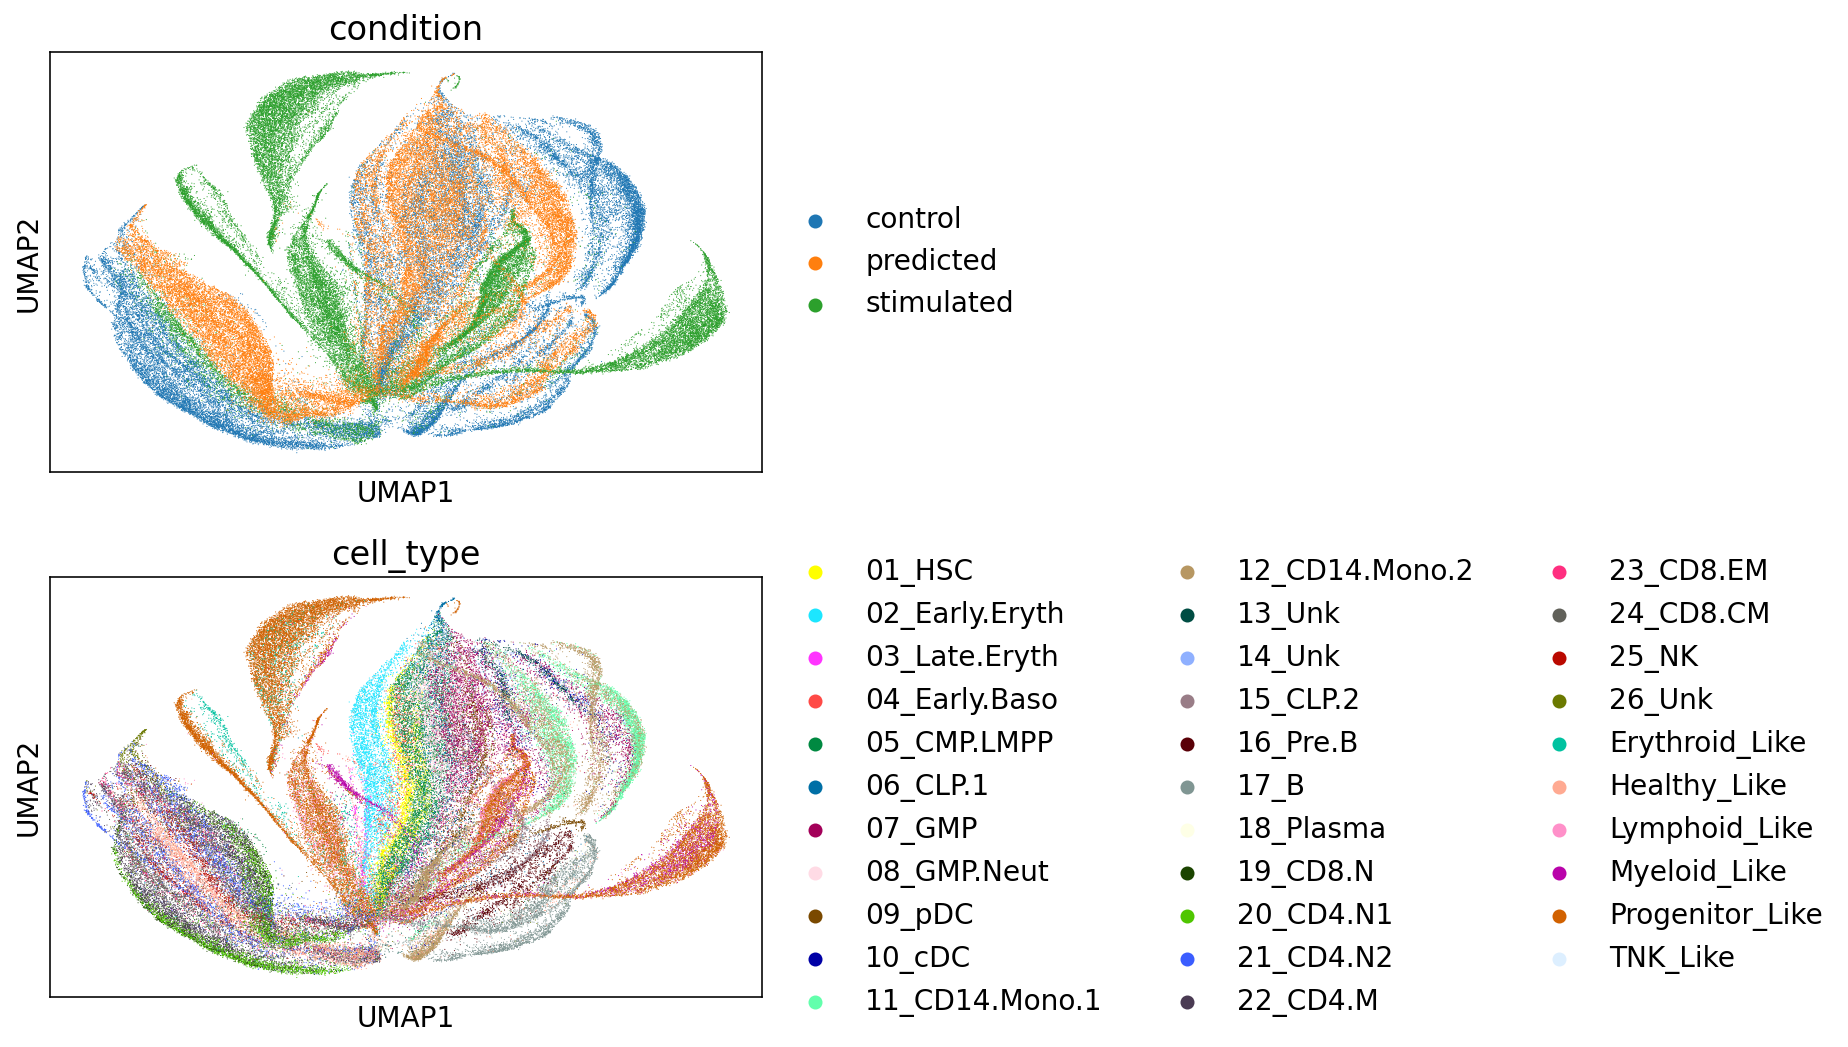

In [16]:
sc.pp.neighbors(all_adata, random_state=42)
sc.tl.umap(all_adata, random_state=42)
sc.pl.umap(all_adata, color=['condition', 'cell_type'], ncols=1)

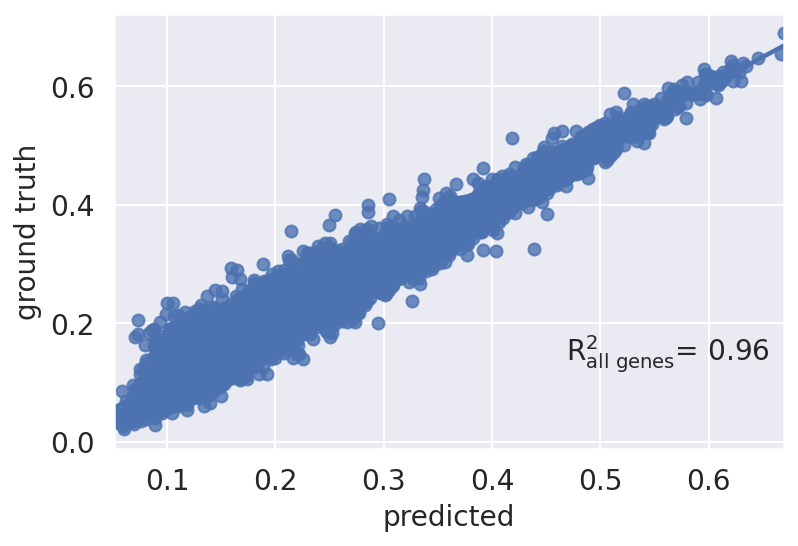

In [17]:
r2_value = scgen.plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={"x": "predicted", "y": "stimulated"},
                                        labels={"x": "predicted", "y": "ground truth"},
                                        show=True,
                                        legend=False)

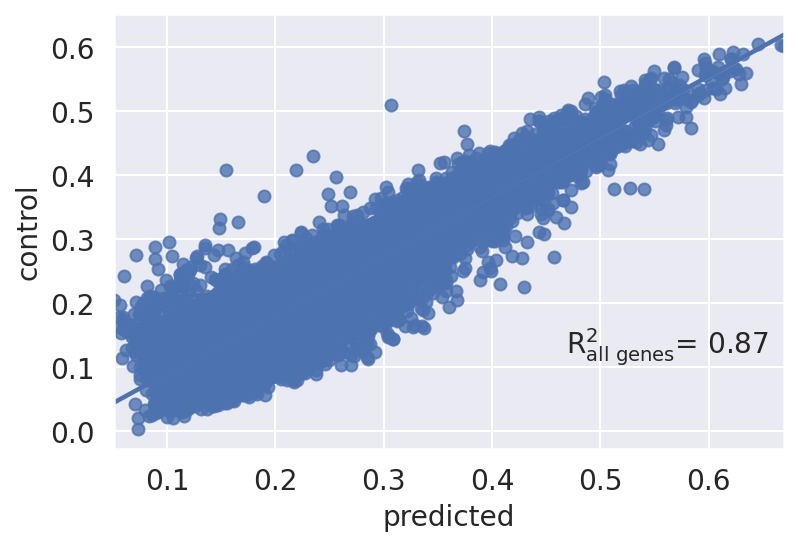

In [18]:
r2_value = scgen.plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={"x": "predicted", "y": "control"},
                                        labels={"x": "predicted", "y": "control"},
                                        show=True,
                                        legend=False)

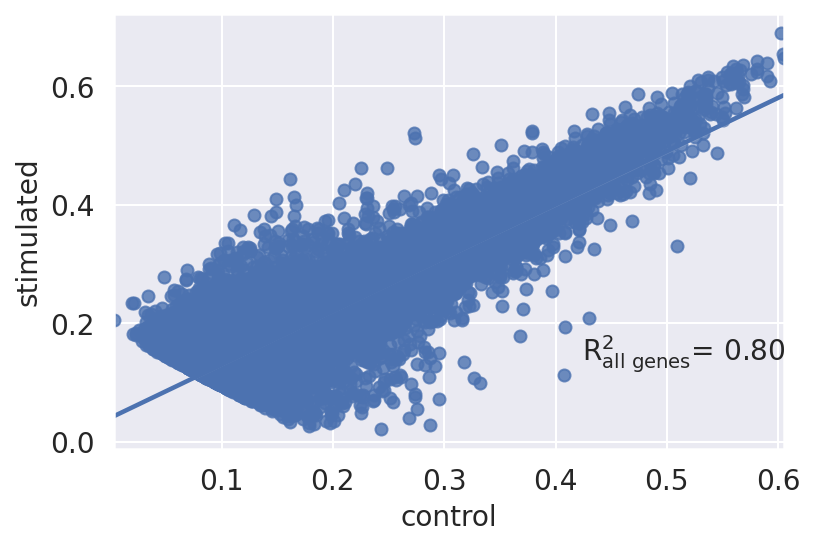

In [19]:
r2_value = scgen.plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={"x": "control", "y": "stimulated"},
                                        labels={"x": "control", "y": "stimulated"},
                                        show=True,
                                        legend=False)